# This notebook will provide details on metadata extraction process before and after finetuning on Environmental Justice Datasets

# Installing the required packages

In [1]:
!pip install -e .
!pip install spacy
!pip install pandas
!pip install openpyxl
!pip install beautifulsoup4
!pip install sentence_transformers
!pip install bert_score
!pip install python-dotenv
!pip install instructor
!pip install loguru
!pip install nltk
!pip install unstructured
!pip install python-docx 
!pip install exceptions
!pip install pypdf
!pip install langchain
!python3 -m spacy download en_core_web_lg
!pip install git+https://git@github.com/NASA-IMPACT/larch.git

Obtaining file:///Users/rajashreedahal/Desktop/workshop/smd-llm-workshop/notebooks
ERROR: file:///Users/rajashreedahal/Desktop/workshop/smd-llm-workshop/notebooks does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
  Using cached rapidfuzz-3.6.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached rapidfuzz-3.6.1-cp310-cp310-macosx_11_0_arm64.whl (1.2 MB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: rapidfuzz
    Found existing installation: rapidfuzz 3.4.0
    Uninstalling rapidfuzz-3.4.0:
      Successfully uninstalled rapidfuzz-3.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

## Importing necessary modules and packages

In [2]:
import json
import os
import re
import ssl
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import instructor
from loguru import logger
from openai import OpenAI
from pydantic import BaseModel,Field
from typing import Literal
import pandas as pd
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from functools import cache
from typing import Callable, List, Optional, Type
from abc import ABC, abstractmethod
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
# Download NLTK resources
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('stopwords')
# Load environment variables from .env file
load_dotenv()



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rajashreedahal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajashreedahal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing necessary modules from larch:
Larch is a LLM toolbox. The tool tentatively has the following components to create any downstream llm-based search engine.
1. DocumentIndexer
2. MetadataExtractor
3. SearchEngine
4. MetadataValidator
5. MetadataEvaluator
6. TextProcessor

For Environmental Justice metadata extraction, the components we will use are MetadataExtractor and TextProcessor
1. **MetadataExtractor**:
   - **larch.metadata._base.AbstractMetadataExtractor** allows for implementing any downstream metadata extractor.
   - **larch.metadata.extractors_openai.SimpleOpenAIMetadataExtractor**: It is barebone extractor that just hits OpenAI API based on instructor patching. No function calling.
   - **larch.metadata.extractors_openai.InstructorBasedOpenAIMetadataExtractor** is the standard extractor that is recommended to use. This uses function-calling. However, since InstructorBasedOpenAIMetadataExtractor has validation check for schema response, we will manually create a class InstructorBasedOpenAIMetadataExtractor and implement the same method which doesnot require validation
2. **TextProcessor**: larch.processors.TextProcessor allows for processing text. All the text processors takes in a text and egest out processed text.
    - **larch.processors.PIIRemover** uses spacy to identify Personal Identification Information (name, email, phone number) and mask them out.
    - **larch.processors.NonAlphaNumericRemover** removes non-alpha-numeric characters from the text
    - **larch.processors.TextProcessingPipeline** is a container to hold all the text processors and run them sequentially.


In [3]:
from larch.metadata import InstructorBasedOpenAIMetadataExtractor
from larch.processors import PIIRemover, TextProcessingPipeline

# Further details on Metadata Extraction:
*Pydantic*: It is a data validation and settings management library for Python. Pydantic models are Python classes that are used to define the structure and validation rules for data. These models are designed to enforce data integrity by defining the types of data expected, as well as any constraints or validation rules that should be applied.

**How are we using Pydantic in our extraction process??**
*Solution: We will define a schema based on pydantic BaseModel called Environmental Justice and define the variables based on the features we are interested in. We set up potential values of each features either by giving list of options, or some regex patterns that the field value relates to.* 

**Note** *Our model will give output in the designed schema format. Eventhough the format is the same as that of schema, we can't guarrantee that it will hold the regex pattern and field values defined in pydantic schema. For this, we will carryout prompt engineering to make model aware on potential patterns for each variable* 


# Schema Preparation

In [4]:
class Environmental_Justice(BaseModel):
    Indicators: Literal["Disasters","Human Dimensions","Food Availability","Health & Air Quality","Water Availability", "Extreme Heat","Urban Flooding","Climate Change"]
    Geographic_Coverage: str
    Format: str
    Spatial_Resolution: str = Field(pattern=r'^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$')
    Temporal_Resolution: str = Field(pattern=r'^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$')
    Temporal_Extent: str = Field(pattern=r'^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$')
    
schema = Environmental_Justice

In [5]:
from larch.metadata.extractors_openai import SimpleOpenAIMetadataExtractor
class InstructorBasedOpenAIMetadataExtractor(SimpleOpenAIMetadataExtractor):
    """
    This uses `instructor` to hit the OpenAI function calling api.
    Note: The schema for metadata should be of `Type[OpenAISchema]`.
    """

    def _extract(self, text: str):
        if self.debug:
            logger.debug(f"nchars={len(text)}\nText :: {text}")
        schema = instructor.openai_schema(self.schema)
        response = self.openai_client.chat.completions.create(
            model=self.model,
            temperature=0,
            functions=[schema.openai_schema],
            function_call={"name": schema.openai_schema["name"]},
            messages=self._get_messages(text),
        )
        return response  

# Defining the text_processor_pipeline

In [6]:

# Access the API key from the environment
openai_api_key = os.getenv("OPENAI_API_KEY")
text_processor = TextProcessingPipeline(
    lambda x: re.sub(r"\$(?=\w|\n|\()", " ", x).strip(),
    lambda x: re.sub(r"\)(?=\w|\n|\()", " ", x).strip(),
    lambda x: re.sub(r"\#(?=\w|\n|\()", " ", x).strip(),
    lambda x: x.replace("\t", " ").replace("!", " ").strip(),
    PIIRemover()
)


# Metadata Extractions begins from here

# To carry out metadata extractions, we need to do the following steps:
1. Download validation data
2. Preprocess validation data in the desired format
3. Metadata Extractions

# Downloading Validation data
## Exploring contents of validation data

In [7]:
!aws s3 cp 's3://llmworkshop/EJ_validation_data.csv' .
validation_data=pd.read_csv("EJ_validation_data.csv",encoding='latin1')
validation_data.head()

download: s3://llmworkshop/EJ_validation_data.csv to ./EJ_validation_data.csv


,Dataset,Indicators,Description,Description Simplified,Geographic Coverage,Format,Spatial Resolution,Spatial Resolution (Standard),Temporal Resolution,Temporal Extent,Latency,Source/Link,Project,Strengths,Limitations,Data Visualization,Intended Use,Tab Name Indicator,Indicators (Select from drop-down list),sde_link
0,"ABoVE: Burn Severity of Soil Organic Matter, N...",Disasters,This dataset provides maps at 30-m resolution ...,The ABoVE: Burn Severity of Soil Organic Matte...,"Northwest Territories and Northern Alberta, Ca...",GeoTIFF,30 meters,30 meters,NaN,2014-05-01 to 2015-10-01,NaN,https://dx.doi.org/10.3334/ORNLDAAC/1694,ABoVE - Arctic-Boreal Vulnerability Experiment,Pre-classified burn severity for ease of use,Lacks recent data,NaN,Path C,Disasters,Disasters,https://sciencediscoveryengine.nasa.gov/app/na...
1,Daily and Annual PM2.5 Concentrations for the ...,Health & Air Quality,The Daily and Annual PM2.5 Concentrations for ...,The Daily and Annual PM2.5 Concentrations for ...,United States,"raster, tabular, vector",0.00833 degrees,1 kilometer,Daily; Annual,2000-01-01 to 2016-12-31,NaN,https://doi.org/10.7927/0rvr-4538,AQDH - Air Quality Data for Health-Related App...,16-year temporal extent,NaN,SEDAC Map widget,Path B,Health & Air Quality,Health & Air Quality,https://sciencediscoveryengine.nasa.gov/app/na...
2,ECCO Global Mean Sea Level - Daily Mean (Versi...,Climate Change,This dataset provides daily-averaged global me...,The ECCO (Estimating the Circulation and Clima...,Global,netCDF-4,NaN,NaN,NaN,1992-01-01 to 2018-01-01,NaN,https://dx.doi.org/10.5067/ECTSD-MSL44,ECCO - Estimating the Circulation and Climate ...,20-year temporal extent,NaN,NaN,Path C,Climate Change,Climate Change,https://sciencediscoveryengine.nasa.gov/app/na...
3,ECOSTRESS Land Surface Temperature and Emissiv...,Extreme Heat,The ECOsystem Spaceborne Thermal Radiometer Ex...,The ECOSTRESS Land Surface Temperature dataset...,Global,HDF5,70 m,70 meters,Varies,2018-07-09 to Present,NaN,https://dx.doi.org/10.5067/ECOSTRESS/ECO2LSTE.001,ECOSTRESS - ECOsystem Spaceborne Thermal Radio...,Recent data available,Latency unclear,NaN,Path B,Extreme Heat,Extreme Heat,https://sciencediscoveryengine.nasa.gov/app/na...
4,"Food Insecurity Hotspots Data Set, v1 (2009 â...","Food Availability,Human Dimensions",The Food Insecurity Hotspots Data Set consists...,The Food Insecurity Hotspots Dataset shows the...,"Central America, Caribbean Islands, Central As...","raster, vector, map",250 m,250 m,NaN,2009-01-01 to 2019-12-31,NaN,https://doi.org/10.7927/cx02-2587,FOOD - Food Security Data Collection,10-year temporal extent,Limited geographic coverage,https://sedac.ciesin.columbia.edu/data/set/foo...,Path B,Human Dimensions,Human Dimensions,https://sciencediscoveryengine.nasa.gov/app/na...


# Preprocessing the validation data in the desired format. This includes the following steps:
1. Only considering those urls which have doi in it
2. Selecting the features ['Geographic Coverage","Indicators", "Format", "Spatial Resolution", "Temporal Resolution", "Temporal Extent"] for analysis
3. We extract text based response from request for url and preprocess it.

In [8]:
final_data={}
import requests
for each_data in validation_data.iterrows():
    if "doi" in each_data[1].iloc[11]:
        final_data[each_data[1].iloc[11]]={"Indicators":each_data[1].iloc[1],
                  "Geographic_Coverage":each_data[1].iloc[4],
                  "Format":each_data[1].iloc[5],
                  "Spatial_Resolution":each_data[1].iloc[7],
                  "Temporal_Resolution":each_data[1].iloc[8],
                  "Temporal_Extent":each_data[1].iloc[9]}
url_lists=list(final_data.keys())
url_content=[]
urls=[]
for url in url_lists:  
    response=requests.get(url)
    html_page = response.text
    soup = BeautifulSoup(html_page, "html.parser")
    text=soup.get_text()
    text=text.lower()
    # Tokenization
    tokens = word_tokenize(text) 
    # Remove punctuation and make lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    text=" ".join(tokens)
    text = re.sub(r'[\t\n\r\f\v]+', '', text)
    text=re.sub(r'[^\w\s]', '', text)
    url_content.append(text)
    urls.append(url.strip())



# Initial Extractions
## This is carried out using gpt-3.5-turbo-0125 model: 
**gpt-3.5-turbo-0125 model details**
*It is the latest GPT-3.5 Turbo model with higher accuracy at responding in requested formats and a fix for a bug which caused a text encoding issue for non-English language function calls. It returns a maximum of 4,096 output tokens. The context window is upto 16,385 tokens.*

In [9]:
SYSTEM_PROMPT ="Extract metadata and entities details accurately from my requests." + "Metadata extraction for Indicators should clearly be one of the element in the list ['Disasters','Human Dimensions','Food Availability','Health & Air Quality','Water Availability', 'Extreme Heat','Urban Flooding','Climate Change']. Do not create new element for indicators " + "Geographic_Coverage: If multiple countries, write global, else write name of location"+ "Make sure the following fields follow the following regex pattern"+"Spatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$"+"Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$"+"Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$."


In [10]:
metadata_extractor = InstructorBasedOpenAIMetadataExtractor(
    model="gpt-3.5-turbo-0125",
    schema=schema,
    preprocessor=text_processor,system_prompt=SYSTEM_PROMPT,
    debug=False,
)
before_finetuning={}  # It will hold results for all the data for before finetuning extractions
for enum,text in enumerate(url_content):
    split=text.split()
    if len(split)>1900:
        text=" ".join(split[0:1900])  #handles cases when the text tokens exceeds token limit of used model
    result = metadata_extractor(text)
    message=result.choices[0].message.function_call.arguments
    metadata=json.loads(message)
    before_finetuning[urls[enum]]=metadata


## Extracting EJ metadata on Finetuned model


In [12]:
metadata_extractor = InstructorBasedOpenAIMetadataExtractor(
    model="ft:gpt-3.5-turbo-0125:nasa::95blPXsF",system_prompt=SYSTEM_PROMPT,
    schema=schema,
    preprocessor=text_processor,
    debug=False,
)
after_finetuning={} # It will hold results for all the data for after finetuning extractions
for enum,text in enumerate(url_content):
    split=text.split()
    if len(split)>1900:
        text=" ".join(split[0:1900]) #handles cases when the text tokens exceeds token limit
    result = metadata_extractor(text)
    message=result.choices[0].message.function_call.arguments
    metadata=json.loads(message)
    after_finetuning[urls[enum]]=metadata


## Collecting true data in a desirable format

In [13]:
import json
true_data = {}
for i, row in validation_data.iterrows():
    source_link_col = ["Source/Link","Indicators","Geographic Coverage","Format","Spatial Resolution","Spatial Resolution (Standard)","Temporal Resolution","Temporal Extent"]
    alternate_vals=row[source_link_col]
    alternate_vals=list(alternate_vals)
    alternate_values=alternate_vals[1:]
    value={}
    for enum,i in enumerate(source_link_col[1:]):
            value[i]=alternate_values[enum]
    true_data[alternate_vals[0]]=value


## Script preparation for evaluation

In [14]:

# Evaluation Metric: will be used for indicators field
def evaluate_exact_match(predicted, ground_truth):
    predicted=predicted.lower()
    ground_truth=ground_truth.lower()
    if int(predicted == ground_truth)==1:
        return 1
    else:
        #in case of multiple indicators, if one is correct, then it is true prediction
        predicted_indicators=set(predicted.split(","))
        ground_truth_indicators=set(ground_truth.split(","))
        if predicted_indicators.intersection(ground_truth_indicators):
            return 1
    return 0
                                 

# Evaluation Metric: Exact Match or at least one match if multiple
def evaluate_format(predicted, ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    if type(predicted)==float and type(ground_truth)==float:
        return 1  #returning true if both true data and predicted data do not have information about it
    elif type(ground_truth)==float:
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=ground_truth.lower()
    if predicted==ground_truth:
        return 1
    #in case of multiple Formats, if one is correct, then it is true prediction
    predicted_formats = set(predicted.split(","))
    ground_truth_formats = set(ground_truth.split(","))
    if predicted_formats.intersection(ground_truth_formats):
        return 1
    return 0

def evaluate_spatial_resolution(predicted, ground_truth1,ground_truth2):
    """
        We have two features for spatial resolution: Spatial Resolution and Spatial Resolution (Standard).
        Here we are evaluating considering commonality of predicted data with both the ground truths
    """
    predicted = np.nan if predicted=="N/A" else predicted
    if (type(predicted)==float and type(ground_truth1)==float) or (type(predicted)==float and type(ground_truth2)==float) or (type(ground_truth1)==float and type(ground_truth2)==float):
        return 1 #returning true if both true data and predicted data do not have information about it
    elif (type(ground_truth1)==float or type(ground_truth2)==float):
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth1=ground_truth1.lower()
    ground_truth2=ground_truth2.lower()
    if (predicted==ground_truth1) or (predicted==ground_truth2):
        return 1
    # if the above condition fails, we aim to check on only the numerical representation of the true and predicted data and check whether these values are correct or not
    predicted = re.sub(r'[a-zA-Z\(\)\[\]]', '', predicted).strip()
    ground_truth1=re.sub(r'[a-zA-Z\(\)\[\]]', '', ground_truth1).strip()
    ground_truth2=re.sub(r'[a-zA-Z\(\)\[\]]', '', ground_truth2).strip()
    if not (ground_truth1 or ground_truth2) and predicted.find(',') != -1:
        return 1
    ground_truth1=re.sub(r'[^\d.]', '', ground_truth1)
    ground_truth2=re.sub(r'[^\d.]', '', ground_truth2)
    predicted=re.sub(r'[^\d.]', '', predicted)
    if predicted==ground_truth1 or predicted==ground_truth2:
        return 1
    if predicted and ((ground_truth1 and (predicted.replace(" ","")==ground_truth1.replace(" ",""))) or (ground_truth2 and (predicted.replace(" ","")==ground_truth2.replace(" ","")))):
        return 1
    return 0


def evaluate_temporal_resolution_extent(predicted,ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    ground_truth=np.nan if (type(ground_truth)==str and ground_truth.lower()=="nan") else ground_truth
    if type(predicted)==float and type(ground_truth)==float:
        return 1  #returning true if both true data and predicted data do not have information about it
    if type(ground_truth)==float:
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=str(ground_truth).lower()
    if predicted==ground_truth:
        return 1
    predicted = ''.join(re.findall(r'\w', predicted))
    ground_truth=''.join(re.findall(r'\w', ground_truth))
    if predicted==ground_truth:
        return 1 
    return 0    

# Making sure our true data, before_finetuned extractions, after finetuned extractions have the same source of link

In [15]:
truth_data={}
for i, value in true_data.items():
    if not isinstance(i,float):
        truth_data[i.strip()]=value 
true_data=truth_data
intersection_keys = set(before_finetuning.keys()) & set(after_finetuning.keys()) & set(true_data.keys())
before_finetuned={k:before_finetuning[k] for k in intersection_keys}
after_finetuned={k:after_finetuning[k] for k in intersection_keys}
true_data={k:true_data[k] for k in intersection_keys}


## Defining the extraction performance in boolean field: 0 ==> wrong prediction, 1 ==> correct prediction

In [16]:
def boolean_metrics(true_data,pred_data):
    metrics={}
    for key in true_data.keys():
        reject_key=[np.nan]
        if key not in reject_key:
            true_source=true_data[key]
            try:
                pred_source=pred_data[key]
            except:
                pred_source=pred_data[key.strip()]  #removing whitespace characters
            for each_key in pred_source.keys():
                if each_key=="Indicators":
                    result=evaluate_exact_match(pred_source[each_key],true_source[each_key])
                    if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Geographic_Coverage":
                    result=evaluate_format(pred_source[each_key],true_source["Geographic Coverage"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result) 
                        
                elif each_key=="Format":
                    result=evaluate_format(pred_source[each_key],true_source[each_key])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Spatial_Resolution":
                    result=evaluate_spatial_resolution(pred_source[each_key],true_source["Spatial Resolution"],true_source["Spatial Resolution (Standard)"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Temporal_Resolution":
                    result=evaluate_temporal_resolution_extent(pred_source[each_key],true_source["Temporal Resolution"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Temporal_Extent":
                    result=evaluate_temporal_resolution_extent(pred_source[each_key],true_source["Temporal Extent"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
    return metrics

# We will measure accuracy based on obtained boolean result
def get_metrics(predictions):
    aspect_metrics = {}
    for aspect, preds in predictions.items():
        accuracy = accuracy_score(preds, [1]*len(preds))  # Assuming ground truth is always 1
        aspect_metrics[aspect] = accuracy
    return aspect_metrics

## Extracting accuracy metrics on boolean evaluation

In [17]:
before_metrics=boolean_metrics(true_data,before_finetuned)
metrics_before_finetuning=get_metrics(before_metrics)

after_metrics=boolean_metrics(true_data,after_finetuned)
metrics_after_finetuning=get_metrics(after_metrics)


# At this rate, we have following set of informations:
1. True data
2. Metadata Extraction before finetuning
3. Metadata Extraction after finetuning
   
**But What if our defined evaluation system for generated prediction is not enough? What if we are gettting correct result and our system is failing to identify it as correct?**

*Solution1: Lets ask gpt based model to evaluate the performance of features of extracted metadata before and after finetuning by comparing with the ground truth.*

**How are we going to do this?**

*By implementing prompt based gpt evaluation for true and extracted metadata. The prompt implementation is given below:*


*Solution2: Lets perform human evaluation on extracted data before and after finetuning and true data*

**How are we going to do this?**

*We will dump the ground truth and extracted data in a desirable spreasheet format and let human manually define whether its correct or not and then do the analysis*

## Implementing prompt based gpt evaluation for true and extracted metadata

In [18]:
prompt="""You are given a dictionary of true data and its prediction. Based on the information, give boolean result for each 
feature in the data if its true data and prediction are same or nearly same.\
Evaluation criteria are as follows: 
Indicators: if true data and predicted indicator are same, set 1, if one of the predicted indicator is same, set 1, else set 0
Geographic_Coverage: if same, set 1, elif multiple countries in one and global in another, set 1, if both nan set 1 else 0
Format: if true format and predicted format are same, set 1, elif few samples are similar, set 1, if both nan the set 1 else set 0
Spatial Resolution: if true spatial resolution and predicted spatial resolution are similar or same, set 1, if both are nan set 1 else set 0
Temporal Resolution: if true temporal resolution and predicted temporal resolution are similar or same, set 1, if both are nan set 1 else set 0
Output format:
{given url: {"Indicators": 0 or 1,
"Geographic_Coverage": 0 or 1,
"Format": 0 or 1,
"Spatial_Resolution": 0 or 1,
"Temporal_Resolution": 0 or 1,
"Temporal_Extent":0 or 1',
}}
"""


## Evaluating the prompt based model performance by feeding true data, predictions of before and after finetuning on gpt-3.5-turbo model

In [19]:
import openai
openai.api_key=openai_api_key
# Get the iterators for each dictionary
iter1 = iter(true_data.items())
iter2 = iter(before_finetuned.items())
iter3 = iter(after_finetuned.items())
before_data=[]
after_data=[]
openai_client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
while True:
    # Get the next item from each dictionary
    try:
        true = next(iter1)
        before = next(iter2)
        after = next(iter3)
        response_before = openai_client.chat.completions.create(
        model='gpt-3.5-turbo',
        temperature=0,
        messages=[{"role": "system", "content": prompt,},{"role":"user","content":"Prediction: "+str(before)+"True data: "+str(true)}])
        before_data.append(response_before)
        
        response_after = openai_client.chat.completions.create(
        model='gpt-3.5-turbo',
        temperature=0,
        messages=[{"role": "system", "content": prompt,},{"role":"user","content":"Prediction: "+str(after)+"True data: "+str(true)}])
        after_data.append(response_after)
    except StopIteration:
        break

## preprocessing the gpt evaluation in desirable format

In [20]:
gpt_before_metrics={}
for enum, response_before in enumerate(before_data):
    data=response_before.choices[0].message.content
    data=data.replace("'",'"').replace("True","1").replace("False","0").replace(",\n}","}")
    data=json.loads(data)
    url=list(data.keys())
    values=list(data.values())
    
    gpt_before_metrics[url[0]]=values[0]


gpt_after_metrics={}
for enum, response_after in enumerate(after_data):
    data=response_after.choices[0].message.content
    data=data.replace("'",'"').replace("True","1").replace("False","0").replace(",\n}","}")
    data=json.loads(data)
    url=list(data.keys())
    values=list(data.values())
    gpt_after_metrics[url[0]]=values[0]



## converting gpt evaluation in desirable format for measuring accuracy

In [21]:
final_gpt_before_metrics = {}
# Iterate through the dictionary
for url, attributes in gpt_before_metrics.items():
    for key, value in attributes.items():
        if key not in final_gpt_before_metrics:
            final_gpt_before_metrics[key] = []
        final_gpt_before_metrics[key].append(value)

# Convert to the desired format
final_gpt_before_metrics = {key: value for key, value in final_gpt_before_metrics.items()}

final_gpt_after_metrics = {}
# Iterate through the dictionary
for url, attributes in gpt_after_metrics.items():
    for key, value in attributes.items():
        if key not in final_gpt_after_metrics:
            final_gpt_after_metrics[key] = []
        final_gpt_after_metrics[key].append(value)

# Convert to the desired format
finals_gpt_after_metrics = {key: value for key, value in final_gpt_after_metrics.items()}

finals_gpt_before_metrics=get_metrics(final_gpt_before_metrics)
finals_gpt_after_metrics=get_metrics(final_gpt_after_metrics)


## Comparing the performance of model before and after finetuning using defined evaluation metrics

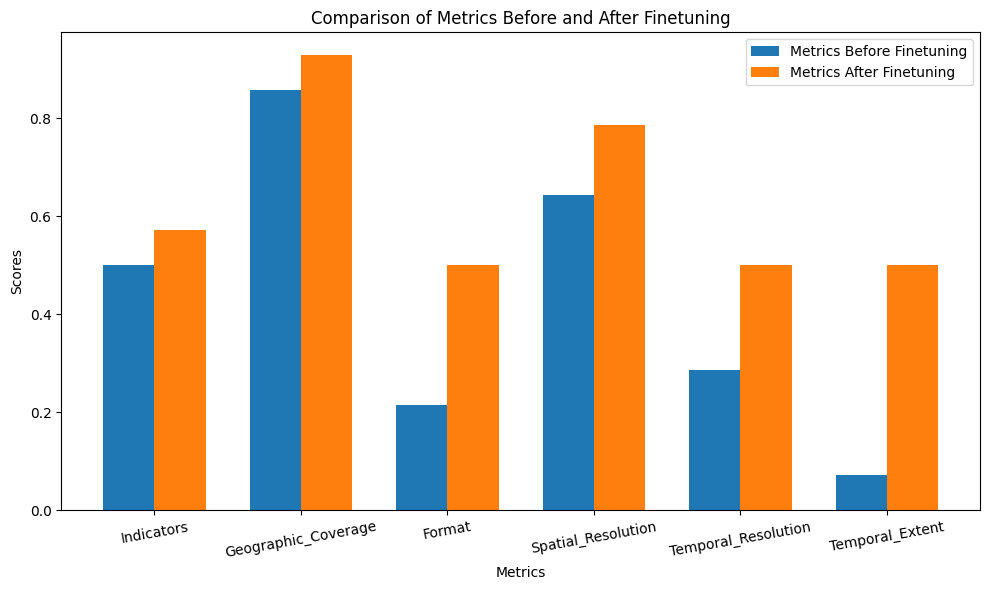

In [22]:
import matplotlib.pyplot as plt
keys = list(finals_gpt_before_metrics.keys())

metrics_before_values = list(metrics_before_finetuning.values())
metrics_after_values = list(metrics_after_finetuning.values())

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bar graphs
bar_width = 0.35
x = range(len(keys))  # X-axis positions for bars
plt.bar(x, metrics_before_values, width=bar_width, label='Metrics Before Finetuning')
plt.bar([pos + bar_width for pos in x], metrics_after_values, width=bar_width, label='Metrics After Finetuning')

plt.title('Comparison of Metrics Before and After Finetuning')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks([pos + bar_width/2 for pos in x], keys, rotation=10)  # Setting keys as x-axis labels

plt.legend()
plt.grid(False)
plt.tight_layout()

# Comparing the performance of model before and after finetuning using GPT based evaluation

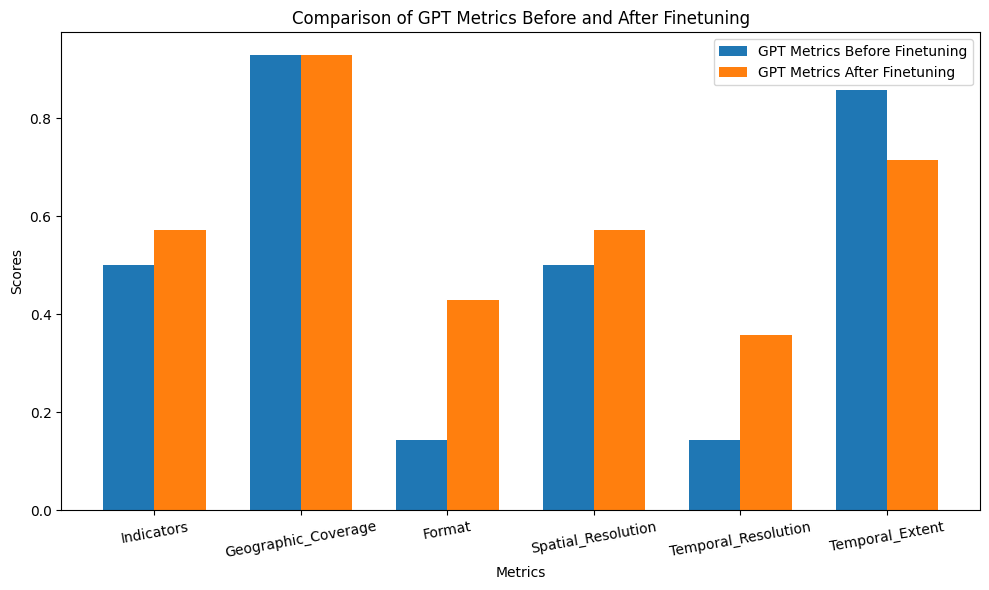

In [23]:
gpt_before_values = list(finals_gpt_before_metrics.values())
gpt_after_values = list(finals_gpt_after_metrics.values())

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bar graphs
bar_width = 0.35
x = range(len(keys))  # X-axis positions for bars
plt.bar(x, gpt_before_values, width=bar_width, label='GPT Metrics Before Finetuning')
plt.bar([pos + bar_width for pos in x], gpt_after_values, width=bar_width, label='GPT Metrics After Finetuning')

plt.title('Comparison of GPT Metrics Before and After Finetuning')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks([pos + bar_width/2 for pos in x], keys, rotation=10)  # Setting keys as x-axis labels

plt.legend()
plt.grid(False)
plt.tight_layout()


## Converting the ground_truth and before and after finetuning extractions in the desirable excel format for human level evaluation

In [24]:
urls=list(true_data.keys())
columns=["Indicators","Indicators_before","Indicators_after","H_Indicator_before","H_Indicator_after",
         "Geographic Coverage","Geographic_Coverage_before","Geographic_Coverage_after","H_Geographic_Coverage_before","H_Geographic_Coverage_after",
         "Format","Format_before","Format_after","H_Format_before","H_Format_after",
         "Spatial Resolution","Spatial Resolution (Standard)","Spatial_Resolution_before","Spatial_Resolution_after","H_Spatial_Resolution_before","H_Spatial_Resolution_after",
         "Temporal Resolution","Temporal_Resolution_before","Temporal_Resolution_after","H_Temporal_Resolution_before","H_Temporal_Resolution_after",
         "Temporal Extent","Temporal_Extent_before","Temporal_Extent_after","H_Temporal_Extent_before","H_Temporal_Extent_after"]
human_evaluation=pd.DataFrame(columns=columns)
for each_url in urls:
    tru={"urls":each_url}
    true_details=true_data[each_url]
    tru.update(true_details)
    before_details=before_finetuned[each_url]
    before_details={i+str("_before"):v for i,v in before_details.items()}
    tru.update(before_details)
    after_details=after_finetuned[each_url]
    after_details={i+str("_after"):v for i,v in after_details.items()}
    tru.update(after_details)
    new_data = pd.DataFrame([tru])
    human_evaluation = pd.concat([human_evaluation, new_data], ignore_index=True)

# Lets look at the dataset before dumping

In [25]:
human_evaluation.head()

,Indicators,Indicators_before,Indicators_after,H_Indicator_before,H_Indicator_after,Geographic Coverage,Geographic_Coverage_before,Geographic_Coverage_after,H_Geographic_Coverage_before,H_Geographic_Coverage_after,...,Temporal_Resolution_before,Temporal_Resolution_after,H_Temporal_Resolution_before,H_Temporal_Resolution_after,Temporal Extent,Temporal_Extent_before,Temporal_Extent_after,H_Temporal_Extent_before,H_Temporal_Extent_after,urls
0,Health & Air Quality,Health & Air Quality,Health & Air Quality,NaN,NaN,Global,global,Global,NaN,NaN,...,N/A,Daily - < Weekly,NaN,NaN,2023-06-01 ongoing,2013 to present,2012-03-13 to Present,NaN,NaN,https://doi.org/10.5067/VIIRS/AERDB_L2_VIIRS_S...
1,Health & Air Quality,Disasters,Human Dimensions,NaN,NaN,Global,global,Global,NaN,NaN,...,N/A,Varies,NaN,NaN,2012-01-26 ongoing,varies,2018-01-01 to 2020-12-31,NaN,NaN,https://dx.doi.org/10.5067/MEASURES/SO2/DATA205
2,Climate Change,Water Availability,Climate Change,NaN,NaN,Global,global,Global,NaN,NaN,...,daily,Daily - < Weekly,NaN,NaN,1992-01-01 to 2018-01-01,varies,1992-01-01 to 2018-01-01,NaN,NaN,https://dx.doi.org/10.5067/ECTSD-MSL44
3,Health & Air Quality,Extreme Heat,Health & Air Quality,NaN,NaN,Global,global,Global,NaN,NaN,...,yearly,Annual,NaN,NaN,1998-01-01 to 2016-12-31,1998-2016,1998-01-01 to 2016-12-31,NaN,NaN,https://doi.org/10.7927/H4ZK5DQS
4,Extreme Heat,Climate Change,Climate Change,NaN,NaN,Global,global,Global,NaN,NaN,...,Daily,Daily - < Weekly,NaN,NaN,2013-04-11 to Present,present,2013-03-11 to Present,NaN,NaN,https://dx.doi.org/10.5067/HLS/HLSL30.002


# Dumping the excel sheet and human manually evaluates it

In [26]:
human_evaluation.to_csv("human_evaluation_demo.csv",index=False)

# Loading updated human evaluation : 
**Note:** H_Indicator_before means Human evaluation of the field Indicator for before finetuing, similarly, H_Indicator_after means human evaluation of the field Indicator for after finetuning

In [27]:
!aws s3 cp s3://llmworkshop/human_evaluation_done.csv .
after_human_evaluation=pd.read_csv("human_evaluation_done.csv",encoding='latin1')
before_columns=['H_Indicator_before',"H_Geographic_Coverage_before",'H_Format_before','H_Spatial_Resolution_before',
         'H_Temporal_Resolution_before','H_Temporal_Extent_before']
after_columns=['H_Indicator_after',"H_Geographic_Coverage_after",'H_Format_after','H_Spatial_Resolution_after','H_Temporal_Resolution_after',
              'H_Temporal_Extent_after']
human_eval_before=after_human_evaluation[before_columns]
human_eval_after=after_human_evaluation[after_columns]


download: s3://llmworkshop/human_evaluation_done.csv to ./human_evaluation_done.csv


# Loading the human evaluation

In [28]:
human_eval_before.head()

,H_Indicator_before,H_Geographic_Coverage_before,H_Format_before,H_Spatial_Resolution_before,H_Temporal_Resolution_before,H_Temporal_Extent_before
0,0,1,0,1,0,0
1,0,1,0,0,1,1
2,1,1,1,0,1,0
3,0,1,0,0,0,0
4,0,1,0,1,1,0


In [29]:
human_eval_after.head()

,H_Indicator_after,H_Geographic_Coverage_after,H_Format_after,H_Spatial_Resolution_after,H_Temporal_Resolution_after,H_Temporal_Extent_after
0,0,1,1,1,1,1
1,1,1,1,0,1,1
2,1,1,1,1,1,1
3,0,1,0,1,0,0
4,0,1,1,1,1,1


# Preprocessing the human evaluation result in a desirable format for visualization

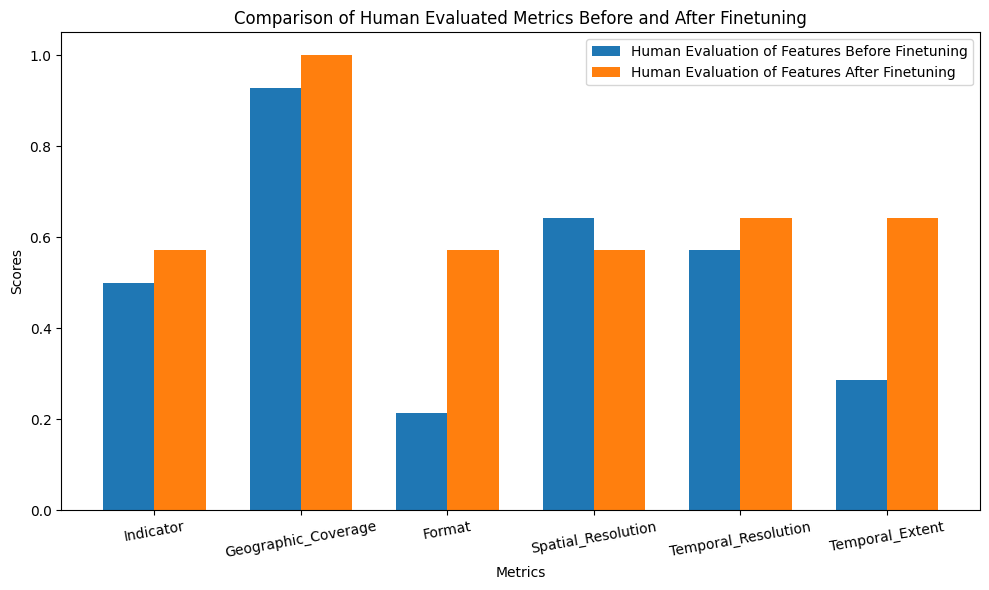

In [30]:
before=human_eval_before.to_dict(orient='list')
before={i.replace("H_","").replace("_before",""):j for i,j in before.items()}

after=human_eval_after.to_dict(orient='list')
after={i.replace("H_","").replace("_after",""):j for i,j in after.items()}

human_before_metrics=get_metrics(before)
human_after_metrics=get_metrics(after)

keys = list(human_before_metrics.keys())
metrics_before_values = list(human_before_metrics.values())
metrics_after_values = list(human_after_metrics.values())

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bar graphs
bar_width = 0.35
x = range(len(keys))  # X-axis positions for bars
plt.bar(x, metrics_before_values, width=bar_width, label='Human Evaluation of Features Before Finetuning')
plt.bar([pos + bar_width for pos in x], metrics_after_values, width=bar_width, label='Human Evaluation of Features After Finetuning')

plt.title('Comparison of Human Evaluated Metrics Before and After Finetuning')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks([pos + bar_width/2 for pos in x], keys, rotation=10)  # Setting keys as x-axis labels

plt.legend()
plt.grid(False)
plt.tight_layout()